<a href="https://colab.research.google.com/github/libra0901/loss-analysis-cka/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In order to execute these set of loss functions on mutliple models, do the following:
#### **Step-1**: *Download **lossfunctions.py** and **train.py** files and add them to your google drive* 

#### **Step-2**: *Mount your drive to the Colab and insert the path via sys library*
#### **Step-3**: *Now, import the files and use as instructed, accordingly.* 

## Mount your google drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Insert the directory to your python path using sys 

In [2]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/')

## Import the mounted libraries

In [3]:
from lossfunctions import LossFunctions 
from train import Train

## Import the required libraries



In [4]:
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as  optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn


## Changing the device to execute on - either CPU or CUDA


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Assign Batch Size and required transformations for your data

In [6]:
batch_size = 256

traindata_transforms = transforms.Compose([
                        transforms.Resize((32,32)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

testdata_transforms = transforms.Compose([
                        transforms.Resize((32,32)),  
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


## Dataloading

In [7]:
traindata = datasets.CIFAR10(root="\PATH", train=True, transform=traindata_transforms, download=True) 
testdata = datasets.CIFAR10(root="\PATH", train=False, transform=traindata_transforms, download=True)

train_dataloader = DataLoader(traindata, batch_size, shuffle=True) 
test_dataloader = DataLoader(testdata, batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Assign:<br/>
-----------------------------------------------------------------------<br/>
Number of classes (w.r.t dataset) = n : int <br/>
-----------------------------------------------------------------------<br/>
Loss Function = (from set of declared 6 loss fucntions, assign one)<br/>
1.   L<sub>1</sub> = expectation_loss<br/>
2.   L<sub>2</sub> = mse_loss<br/>
3.   Softmax Cross Entropy = cross_entropy_loss<br/>
4.   Binary Cross Entropy = bce_loss<br/>
5.   Negative Log-Likelihood = neg_loglike_loss<br/>
6.   Sum-of-Sqaures = sos_loss<br/>
-----------------------------------------------------------------------<br/>
## Execute the model

In [8]:
num_classes = 10
lf = LossFunctions(num_classes)
loss = lf.cross_entropy_loss
batch_size = 512
optimizer = optim.Adam
epochs = 15
modelname = 'resnet18'
dataset = '\cifar10'

# Declaring Loss Function
l = LossFunctions(num_classes)
# Training 
t = Train(optimizer = optimizer,
          loss = loss,
          epochs = epochs,
          modelname = modelname,
          dataset = dataset,
          )
filename = dataset[1:] + modelname

history = t.train(
            train_dl = train_dataloader,
            test_dl = test_dataloader,
            num_classes = num_classes,
            filename = filename,
            dataset = dataset
            )

Epoch [0/15]: 100%|██████████| 196/196 [00:28<00:00,  6.85batch/s, train_acc=0.502, train_loss=1.38]



Epoch 0 {'train_loss': 1.3841039, 'train_acc': 0.50159043, 'test_loss': 0.90480816, 'test_acc': 0.625}


Epoch [1/15]: 100%|██████████| 196/196 [00:24<00:00,  7.90batch/s, train_acc=0.655, train_loss=0.969]



Epoch 1 {'train_loss': 0.9687194, 'train_acc': 0.65540093, 'test_loss': 0.76787454, 'test_acc': 0.6875}


Epoch [2/15]: 100%|██████████| 196/196 [00:25<00:00,  7.78batch/s, train_acc=0.724, train_loss=0.79]



Epoch 2 {'train_loss': 0.7897619, 'train_acc': 0.724139, 'test_loss': 0.6521969, 'test_acc': 0.75}


Epoch [3/15]: 100%|██████████| 196/196 [00:24<00:00,  7.96batch/s, train_acc=0.77, train_loss=0.656]



Epoch 3 {'train_loss': 0.65621215, 'train_acc': 0.7702647, 'test_loss': 1.1807548, 'test_acc': 0.5625}


Epoch [4/15]: 100%|██████████| 196/196 [00:24<00:00,  7.87batch/s, train_acc=0.807, train_loss=0.551]



Epoch 4 {'train_loss': 0.55125546, 'train_acc': 0.8067722, 'test_loss': 0.72996074, 'test_acc': 0.6875}


Epoch [5/15]: 100%|██████████| 196/196 [00:24<00:00,  8.03batch/s, train_acc=0.842, train_loss=0.447]



Epoch 5 {'train_loss': 0.4465295, 'train_acc': 0.8424267, 'test_loss': 0.50216275, 'test_acc': 0.75}


Epoch [6/15]: 100%|██████████| 196/196 [00:24<00:00,  8.08batch/s, train_acc=0.87, train_loss=0.37]



Epoch 6 {'train_loss': 0.3698096, 'train_acc': 0.8696588, 'test_loss': 0.6414493, 'test_acc': 0.75}


Epoch [7/15]: 100%|██████████| 196/196 [00:24<00:00,  8.05batch/s, train_acc=0.898, train_loss=0.289]



Epoch 7 {'train_loss': 0.28902274, 'train_acc': 0.89791536, 'test_loss': 0.6191842, 'test_acc': 0.8125}


Epoch [8/15]: 100%|██████████| 196/196 [00:24<00:00,  8.00batch/s, train_acc=0.915, train_loss=0.242]



Epoch 8 {'train_loss': 0.24203561, 'train_acc': 0.9146724, 'test_loss': 0.42509538, 'test_acc': 0.875}


Epoch [9/15]: 100%|██████████| 196/196 [00:24<00:00,  8.05batch/s, train_acc=0.929, train_loss=0.197]



Epoch 9 {'train_loss': 0.19708012, 'train_acc': 0.92927295, 'test_loss': 1.0624489, 'test_acc': 0.6875}


Epoch [10/15]: 100%|██████████| 196/196 [00:24<00:00,  8.13batch/s, train_acc=0.945, train_loss=0.157]



Epoch 10 {'train_loss': 0.15725212, 'train_acc': 0.944611, 'test_loss': 0.68196374, 'test_acc': 0.8125}


Epoch [11/15]: 100%|██████████| 196/196 [00:24<00:00,  8.15batch/s, train_acc=0.956, train_loss=0.127]



Epoch 11 {'train_loss': 0.1270857, 'train_acc': 0.9556561, 'test_loss': 0.899916, 'test_acc': 0.875}


Epoch [12/15]: 100%|██████████| 196/196 [00:24<00:00,  8.02batch/s, train_acc=0.956, train_loss=0.123]



Epoch 12 {'train_loss': 0.122677006, 'train_acc': 0.9561703, 'test_loss': 1.3670872, 'test_acc': 0.75}


Epoch [13/15]: 100%|██████████| 196/196 [00:24<00:00,  8.16batch/s, train_acc=0.962, train_loss=0.106]



Epoch 13 {'train_loss': 0.10639354, 'train_acc': 0.9620456, 'test_loss': 0.9347658, 'test_acc': 0.75}


Epoch [14/15]: 100%|██████████| 196/196 [00:24<00:00,  8.09batch/s, train_acc=0.969, train_loss=0.0892]



Epoch 14 {'train_loss': 0.089245796, 'train_acc': 0.96932, 'test_loss': 1.4637591, 'test_acc': 0.75}
Training Completed in 7 min 15 sec


## Visualize the Model's **CKA**
Code referral have been provided in the "***Code References***" section in **README.md**


In [9]:
pip install torch_cka

In [12]:
from torch_cka import CKA
model1 = models.resnet18(pretrained=True)  # Or any neural network of your choice
model2 = models.resnet18(pretrained=False)

# # or # 

# model1 = torch.load(r'\PATH') ## Load Model Path
# model1.load_state_dict(torch.load(r'PATH')) ## Load Model Weights Path
# model2 = torch.load(r'\PATH') ## Load Model Path
# model2.load_state_dict(torch.load(r'PATH')) ## Load Model Weights Path

dataloader = DataLoader(testdata, 
                        batch_size=batch_size, # according to your device memory
                        shuffle=False)  # Don't forget to seed your dataloader

cka = CKA(model1, model2,
          model1_name="ResNet18 PT=True",   # good idea to provide names to avoid confusion
          model2_name="ResNet18 PT=False",   
#          model1_layers=layer_names_resnet18, # List of layers to extract features from
#          model2_layers=layer_names_resnet34, # extracts all layer features by default
          device='cuda')

cka.compare(dataloader) # secondary dataloader is optional

results = cka.export()  # returns a dict that contains model names, layer names
                        # and the CKA matrix


/usr/local/lib/python3.7/dist-packages/torch_cka/cka.py:145: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
| Comparing features |: 100%|██████████| 20/20 [03:41<00:00, 11.09s/it]


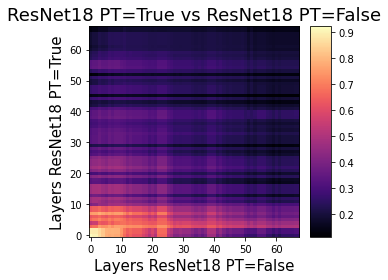

In [14]:
cka.plot_results()